In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

In [ ]:
empirical_data = pd.read_csv("simulation_results/clean_data/outside_temp_pid_nominal.csv")

true_data = pd.read_csv("simulation_results/clean_data/all_temperatures.csv")

print(f"Empirical Data Shape: {empirical_data.shape}")
print(empirical_data.head())
print(true_data.head())

Empirical Data Shape: (100, 2)
   Unnamed: 0  outsideTemp
0           0          9.0
1           1          9.4
2           2          5.0
3           3          8.6
4           4          4.9
   temp
0   7.3
1   6.6
2   5.8
3   5.6
4   5.1


In [3]:
# Pre processing data

empirical_data.rename(columns={"outsideTemp": "temp"}, inplace=True)
empirical_data = empirical_data["temp"].to_frame()

true_data["quantile"] = pd.qcut(true_data["temp"], q=11)

# Associate empirical data with true data quantiles
# Each empirical data point is assigned to the quantile of the true data
empirical_data["quantile"] = pd.cut(
    empirical_data["temp"],
    bins=true_data["quantile"].cat.categories,
    labels=true_data["quantile"].cat.codes,
)

quantiles_data = empirical_data.groupby("quantile", observed=False).count().reset_index()
quantiles_data.rename(columns={"temp": "percentage"}, inplace=True)
quantiles_data["percentage"] = quantiles_data["percentage"] / quantiles_data["percentage"].sum()


print("Empirical Data:")
print(empirical_data.head())
print("True Data:")
print(true_data.head())
print("Quantiles Data:")
print(quantiles_data.head(20))

Empirical Data:
   temp      quantile
0   9.0    (8.5, 9.6]
1   9.4    (8.5, 9.6]
2   5.0  (4.218, 5.1]
3   8.6    (8.5, 9.6]
4   4.9  (4.218, 5.1]
True Data:
   temp      quantile
0   7.3    (7.0, 7.7]
1   6.6    (6.3, 7.0]
2   5.8  (5.636, 6.3]
3   5.6  (5.1, 5.636]
4   5.1  (4.218, 5.1]
Quantiles Data:
         quantile  percentage
0   (-3.401, 3.1]        0.05
1    (3.1, 4.218]        0.13
2    (4.218, 5.1]        0.13
3    (5.1, 5.636]        0.02
4    (5.636, 6.3]        0.11
5      (6.3, 7.0]        0.06
6      (7.0, 7.7]        0.15
7      (7.7, 8.5]        0.08
8      (8.5, 9.6]        0.12
9     (9.6, 11.5]        0.09
10   (11.5, 19.8]        0.06


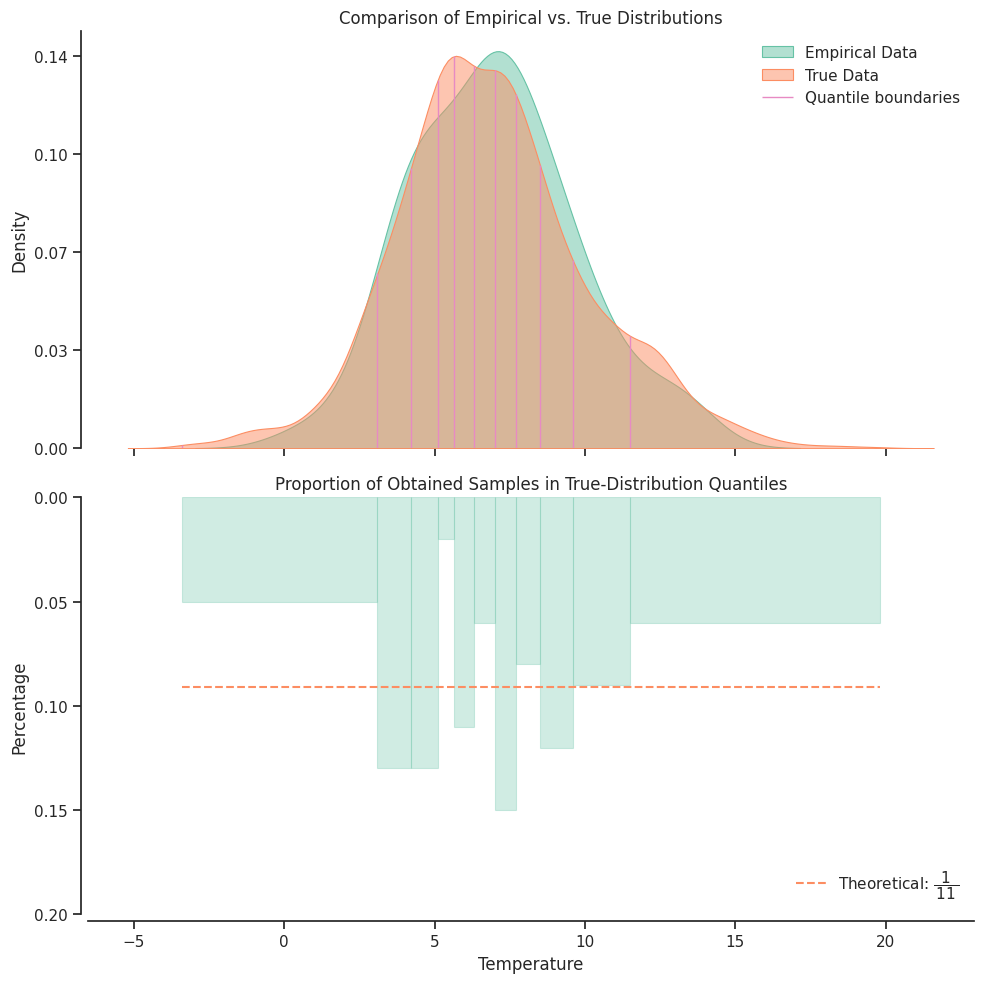

In [4]:
# ------------- Configuration -------------
custom_rc = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": False,
}
palette = sns.color_palette("Set2")

sns.set_theme(style="ticks", rc=custom_rc, palette=palette)

# ------------- Data & KDE Setup -------------
temps = true_data["temp"].values
kde = gaussian_kde(temps)
m = len(quantiles_data)
theoretical_p = 1.0 / m

# ------------- Create Subplots -------------
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(10, 10), sharex=True
)

# ---- TOP: Empirical vs True KDEs ----
for data, label, color in [
    (empirical_data, "Empirical Data", None),
    (true_data,      "True Data",      None)
]:
    sns.kdeplot(
        data=data, x="temp",
        fill=True, common_norm=False,
        alpha=0.5, linewidth=0.8,
        label=label,
        ax=ax1
    )

# Quantile boundaries up to true density
for idx, q in enumerate(quantiles_data["quantile"]):
    x0 = q.left
    ax1.vlines(
        x=x0,
        ymin=0,
        ymax=kde(x0)[0],
        color=palette[3],
        linewidth=1,
        # alpha=0.,
        label="Quantile boundaries" if idx == 0 else None
    )
# Rightmost boundary
x_max = quantiles_data["quantile"].max().right
ax1.vlines(
    x=x_max,
    ymin=0,
    ymax=kde(x_max)[0],
    color=palette[2],
    linewidth=0.8,
    alpha=0.5
)

# Y‐ticks for density plot
density_ticks = np.linspace(0, np.max(kde(temps)), 5)
density_labels = [f"{t:.2f}" for t in density_ticks]
ax1.set_yticks(density_ticks)
ax1.set_yticklabels(density_labels)

# Titles & Labels
ax1.set_title("Comparison of Empirical vs. True Distributions")
ax1.set_ylabel("Density")
ax1.legend(frameon=False)

# ---- BOTTOM: Quantile Proportions ----
# Bars
for _, row in quantiles_data.iterrows():
    left, right = row["quantile"].left, row["quantile"].right
    width = right - left
    pct = row["percentage"]
    center = left + width / 2
    ax2.bar(
        x=center,
        height=-pct,
        width=width,
        align="center",
        alpha=0.3,
        edgecolor=palette[0],
        color=palette[0],
        linewidth=0.8
    )
# Theoretical line
ax2.hlines(
    y=-theoretical_p,
    xmin=true_data["temp"].min(),
    xmax=true_data["temp"].max(),
    color=palette[1],
    linestyle="--",
    linewidth=1.5,
    label=r"Theoretical: $\dfrac{1}{\,%d\,}$" % m
)

# Y‐ticks for proportion plot
prop_ticks = np.array([0.00, 0.05, 0.10, 0.15, 0.20])
ax2.set_yticks(-prop_ticks)
ax2.set_yticklabels([f"{v:.2f}" for v in prop_ticks])
ax2.yaxis.set_ticks_position("left")
ax2.tick_params(axis="y", which="both", left=True, labelleft=True)

# Titles & Labels
ax2.set_title("Proportion of Obtained Samples in True-Distribution Quantiles")
ax2.set_ylabel("Percentage")
ax2.set_xlabel("Temperature")
ax2.legend(frameon=False, loc="lower right")

# Despine & Layout
sns.despine(ax=ax1, top=True, right=True, left=False, bottom=True, offset=5)
sns.despine(ax=ax2, top=True, right=True, left=False, offset=5)
plt.tight_layout()
plt.show()

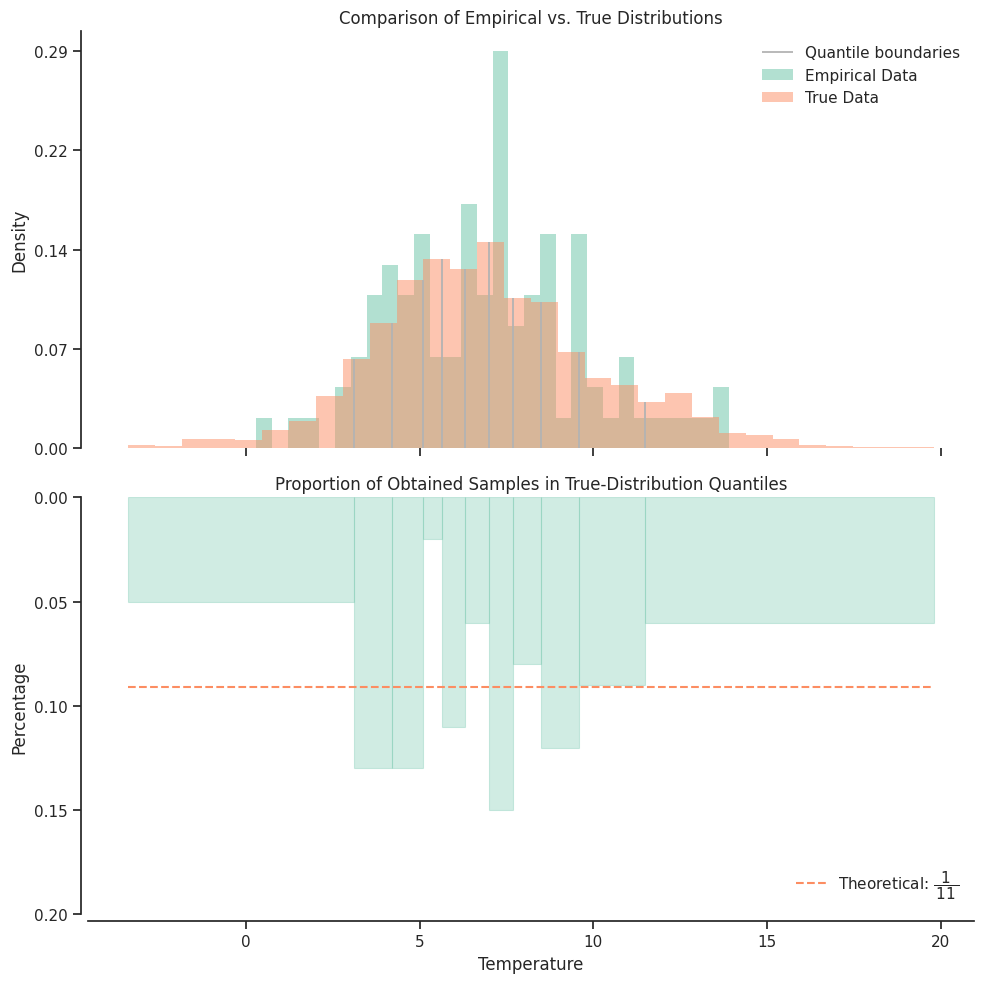

In [5]:
# ------------- Configuration -------------
custom_rc = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": False,
}
palette = sns.color_palette("Set2")

sns.set_theme(style="ticks", rc=custom_rc, palette=palette)

# ------------- Data & KDE Setup -------------
temps = true_data["temp"].values
n_bins = 30
m = len(quantiles_data)
theoretical_p = 1.0 / m

# ------------- Create Subplots -------------
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# ---- TOP: Empirical vs True KDEs ----
for data, label, color in [
    (empirical_data, "Empirical Data", None),
    (true_data, "True Data", None),
]:
    sns.histplot(
        data=data,
        x="temp",
        fill=True,
        alpha=0.5,
        linewidth=0,
        bins=n_bins,
        stat="density",
        label=label,
        ax=ax1,
    )

# Quantile boundaries up to corresponding bar height
bin_edges = np.histogram_bin_edges(true_data["temp"], bins=n_bins)
bin_heights, _ = np.histogram(true_data["temp"], bins=bin_edges, density=True)
empirical_bin_heights, _ = np.histogram(
    empirical_data["temp"],
    bins=np.histogram_bin_edges(empirical_data["temp"], bins=n_bins),
    density=True,
)

for idx, q in enumerate(quantiles_data["quantile"]):
    x0 = q.left
    # Find the bin this boundary falls into
    bin_index = np.searchsorted(bin_edges, x0, side="right") - 1
    bin_height = bin_heights[bin_index] if 0 <= bin_index < len(bin_heights) else 0

    ax1.vlines(
        x=x0,
        ymin=0,
        ymax=bin_height,
        color=palette[7],
        linewidth=1.3,
        label="Quantile boundaries" if idx == 0 else None,
    )

# Rightmost boundary
x_max = quantiles_data["quantile"].max().right
bin_index = np.searchsorted(bin_edges, x_max, side="right") - 1
bin_height = bin_heights[bin_index] if 0 <= bin_index < len(bin_heights) else 0
ax1.vlines(x=x_max, ymin=0, ymax=bin_height, color=palette[7], linewidth=1.3)

# Y‐ticks for density plot
density_ticks = np.linspace(
    0, np.max([np.max(bin_heights), np.max(empirical_bin_heights)]), 5
)
density_labels = [f"{t:.2f}" for t in density_ticks]
ax1.set_yticks(density_ticks)
ax1.set_yticklabels(density_labels)

# Titles & Labels
ax1.set_title("Comparison of Empirical vs. True Distributions")
ax1.set_ylabel("Density")
ax1.legend(frameon=False)

# ---- BOTTOM: Quantile Proportions ----
# Bars
for _, row in quantiles_data.iterrows():
    left, right = row["quantile"].left, row["quantile"].right
    width = right - left
    pct = row["percentage"]
    center = left + width / 2
    ax2.bar(
        x=center,
        height=-pct,
        width=width,
        align="center",
        alpha=0.3,
        edgecolor=palette[0],
        color=palette[0],
        linewidth=0.8,
    )
# Theoretical line
ax2.hlines(
    y=-theoretical_p,
    xmin=true_data["temp"].min(),
    xmax=true_data["temp"].max(),
    color=palette[1],
    linestyle="--",
    linewidth=1.5,
    label=r"Theoretical: $\dfrac{1}{\,%d\,}$" % m,
)

# Y‐ticks for proportion plot
prop_ticks = np.array([0.00, 0.05, 0.10, 0.15, 0.20])
ax2.set_yticks(-prop_ticks)
ax2.set_yticklabels([f"{v:.2f}" for v in prop_ticks])
ax2.yaxis.set_ticks_position("left")
ax2.tick_params(axis="y", which="both", left=True, labelleft=True)

# Titles & Labels
ax2.set_title("Proportion of Obtained Samples in True-Distribution Quantiles")
ax2.set_ylabel("Percentage")
ax2.set_xlabel("Temperature")
ax2.legend(frameon=False, loc="lower right")

# Despine & Layout
sns.despine(ax=ax1, top=True, right=True, left=False, bottom=True, offset=5)
sns.despine(ax=ax2, top=True, right=True, left=False, offset=5)
plt.tight_layout()
plt.show()

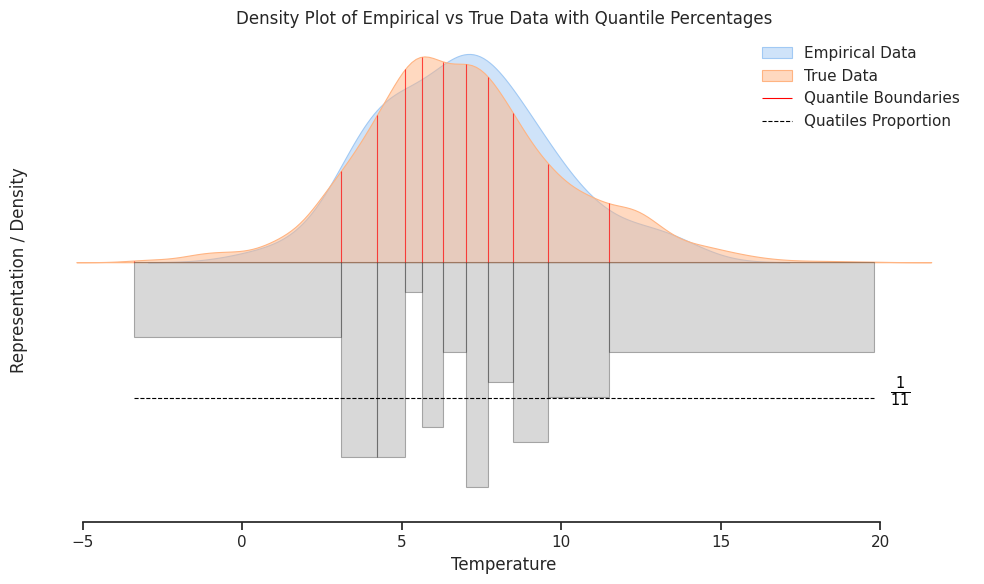

In [6]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "axes.spines.left": False,
}

sns.set_theme(style="ticks", palette="pastel", rc=custom_params)

plt.figure(figsize=(10, 6))
ax = sns.kdeplot(
    data=empirical_data,
    x="temp",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0.8,
    # color="blue",
    label="Empirical Data",
)
ax = sns.kdeplot(
    data=true_data,
    x="temp",
    fill=True,
    linewidth=0.8,
    common_norm=False,
    alpha=0.5,
    # color="orange",
    label="True Data",
)


temps = true_data["temp"].values
kde = gaussian_kde(temps)

# Add vertical quantile boundaries up to true density value
for quantile in quantiles_data["quantile"].unique():
    boundary = quantile.left
    density = kde(boundary)

    ax.vlines(
        x=boundary,
        ymin=0,
        ymax=density,
        color="red",
        # linestyle="--",
        linewidth=0.8,
        alpha=0.7,
    )

# Add final rightmost boundary
ax.vlines(
    x=quantiles_data["quantile"].max().right,
    ymin=0,
    ymax=kde(quantiles_data["quantile"].max().right),
    color="red",
    # linestyle="--",
    linewidth=0.8,
    # alpha=0.7,
    label="Quantile Boundaries",
)

# Add downward bars for quantile percentages
for _, row in quantiles_data.iterrows():
    q_start = row["quantile"].left
    q_end = row["quantile"].right
    q_width = q_end - q_start
    percentage = row["percentage"]

    # Bar parameters
    bar_x = q_start
    bar_height = -percentage  # Negative for downward bar
    bar_center = q_start + q_width / 2

    ax.bar(
        x=bar_center,
        height=bar_height,
        width=q_width,
        align="center",
        color="gray",
        alpha=0.3,
        linewidth=0.8,
        edgecolor="black",
    )

# Add horizontal line -1/len(quantiles_data) to indicate average percentage
average_percentage = -1 / len(quantiles_data)
ax.hlines(
    y=average_percentage,
    xmin=quantiles_data["quantile"].min().left,
    xmax=quantiles_data["quantile"].max().right,
    color="black",
    linestyle="--",
    linewidth=0.8,
    label="Quatiles Proportion"
)

# annotate the average percentage line
ax.annotate(
    r"$\frac{1}{%d}$" % len(quantiles_data),
    xy=(quantiles_data["quantile"].max().right, average_percentage),
    xytext=(quantiles_data["quantile"].max().right + 0.5, average_percentage),
    fontsize=15,
    color="black",
)


plt.title("Density Plot of Empirical vs True Data with Quantile Percentages")
plt.xlabel("Temperature")
plt.ylabel("Representation / Density")
plt.yticks([])
sns.despine(left=True, offset=10, trim=True)
plt.legend(
    frameon=False,
)
plt.tight_layout()
plt.show()